## Import libraries

In [1]:
# standard libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 30) 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import math
# plt.figure(figsize=(16,6))  # set the plot size
# plt.ylim(-0.01, 0.04)  # set the axis zoom range
# plt.xlim(-0.01, 0.04)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

In [4]:
pd.read_sql("""
			create table wandajuan.tmp_llcm_ts as (
				with vp as (
					-- dt | house_id | # unique web view sess | # unique app view sess
					select coalesce(web.dt, app.dt) as dt,
							coalesce(web.house_id, app.house_id) as house_id,
							web.nunique_web_sess,
							app.nunique_app_sess
					from (
						select 	dt, 
								if(page_id is null, cast(regexp_extract(url, '(.*pv~)(\d+)(.*)', 2) as bigint), page_id) as house_id,
								count(distinct session_id) as nunique_web_sess
						from l2.page_views_daily
						where dt >= '2020-01-01'
						and page_behavior in ('pvp', 'VIEW_PRODUCT') 
						group by 1, 2
					) web
					
					full outer join (
						select 
							dt,
							cast(object_id as bigint) as house_id, 
							count(distinct session_id) as nunique_app_sess
						from l2.mobile_client_event -- app sess 
						where event_type = 'View'
						and object_id is not null and entity_type = 'Product'
						and (context <> 'Back' or context is null)
						and dt >= '2020-01-01'
						group by 1, 2
					) app
					on web.dt = app.dt and web.house_id = app.house_id

				),

				mpo as (
					select 
						substr(created, 1, 10) order_date,
						house_id,
						count(1) as units_sold,
						count(distinct order_id) as num_orders,
						sum(COALESCE(i.product_price,0) + COALESCE(i.shipping,0)) GMV,

						sum(COALESCE(i.product_price,0) + COALESCE(i.shipping,0) 
						+ (case when direct_seller in (1,2,3,4,5) then initial_cost_of_product_amount else 0.00 end) 
						+ initial_cost_of_shipping_at_placement) as initial_profit,

						sum(COALESCE(i.product_price,0) + COALESCE(i.shipping,0) 
						+ (case when direct_seller in (1,2,3,4,5) then initial_cost_of_product_amount else 0.00 end) 
						+ initial_cost_of_shipping_at_placement 
						+ COALESCE(sales_returns,0) + COALESCE(discount_returns,0) + COALESCE(sales_allowances,0)
						- COALESCE(cost_of_prod_amount,0) + COALESCE(cost_of_prod_amount_with_replacement,0) - COALESCE(cost_of_shipping_amount,0)
						+ COALESCE(cost_of_shipping_amount_with_replacement,0) + COALESCE(vendor_cost_refunded_to_houzz,0)) as adj_profit
					from
						mp.order_item_margins_with_replacement i
					where substr(created, 1, 4) >= '2020'
					group by 1 ,2 
				),

				cm_metrics as (

					select dt as cm_order_date, 
							house_id, 
							sum(gmv_w_cancel_est) gmv_w_cancel_est, 
							sum(gmv_w_cancel_est
								+shipping_remittance_w_cancel_est
								+seller_remittance_w_cancel_est
								+direct_vendor_cogs_w_cancel_est
								+pl_sales_cost_w_cancel_est
								+pl_other_cogs_w_cancel_est
								+shipping_n_handling_cost_w_cancel_est
								+warranty_remittance_w_cancel_est
								+wty_gmv_w_cancel_est) initial_margin,
							1.0000*sum(gmv_w_cancel_est
								+shipping_remittance_w_cancel_est
								+seller_remittance_w_cancel_est
								+direct_vendor_cogs_w_cancel_est
								+pl_sales_cost_w_cancel_est
								+pl_other_cogs_w_cancel_est
								+shipping_n_handling_cost_w_cancel_est
								+warranty_remittance_w_cancel_est
								+wty_gmv_w_cancel_est)/sum(gmv_w_cancel_est) initial_margin_rate,
							sum(cm) cm
					from mp.order_item_cm_metrics
					where dt >= '2020-01-01'
					group by 1, 2

				),


				paid as (
					select 
						dt paid_date, 
						house_id,
						sum(spend) spend,
						sum(conv_value) conv_value
					from dm.gl_pla_performance
					where substr(dt, 1, 4) >= '2020'
				--    where dt >= '202-09-01'
					group by 1,2
				)
				, tbl as (
				select 
					coalesce(vp.dt, mpo.order_date) dt,
					vp.house_id, vp.nunique_web_sess, vp.nunique_app_sess,
					mpo.units_sold, mpo.num_orders,
					mpo.GMV, mpo.initial_profit, mpo.adj_profit, 
					cm_metrics.gmv_w_cancel_est, cm_metrics.initial_margin, cm_metrics.initial_margin_rate, cm_metrics.cm,
					paid.spend, paid.conv_value, 
					s.test_group, s.ramp,
					case when vl.seller_type in (0, 5) then '3P'
						else 'Direct' end as seller_type_desc,
					vl.l1_category_name, vl.l2_category_name, vl.l3_category_name, vl.l4_category_name, vl.category_name as leaf_category_name,
					p.pricing_logic 
				from vp
				full outer join mpo
				on vp.house_id = mpo.house_id and vp.dt = mpo.order_date
				left join cm_metrics
				on vp.house_id = cm_metrics.house_id and vp.dt = cm_metrics.cm_order_date
				left join paid
				on vp.house_id = paid.house_id and vp.dt = paid.paid_date
				left join shop.vl_pupil vl
				on vp.house_id = vl.house_id
				left join wandajuan.llcm_leaf_split s
				on vl.category_name = s.leaf_category 
				left join shop.mp_pricing_master_table p
				on vl.vendor_listing_id = p.vendor_listing_id 
				where vl.all_status_valid = true and vl.preferred_vendor_listing_id = vl.vendor_listing_id 
				)
				, tbl2 as (
				select 
						tbl.*
						, cd.wk
				from tbl 
				left join (
						select  *, 
							cast(year as varchar)||'W'||cast(lag(cast(week_of_year as int) -1) over (order by date) as varchar) wk
						from mp.cal_dim
						where year >= 2020
					) cd
					on tbl.dt = cd.date
				)
				select dt, wk, test_group, ramp, seller_type_desc, l1_category_name, l2_category_name, l3_category_name, l4_category_name, leaf_category_name, pricing_logic,
						sum(nunique_web_sess) nunique_web_sess, sum(nunique_app_sess) nunique_app_sess,
						sum(units_sold) units_sold, sum(num_orders) num_orders,
						sum(GMV) GMV, sum(initial_profit) initial_profit, sum(adj_profit) adj_profit,
						sum(gmv_w_cancel_est) gmv_w_cancel_est, sum(initial_margin) initial_margin, avg(initial_margin_rate) avg_initial_margin_rate, sum(cm) cm,
						sum(spend) spend, sum(conv_value) conv_value
				from tbl2
				where seller_type_desc = 'Direct'
				group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11   
			)""", conn)

,rows
0,2176807


In [83]:
%%time
# import daily gmv, spend, cm for each leaf category from 2020
ts = pd.read_sql("""
				select dt, wk, ramp, l1_category_name, l2_category_name, leaf_category_name, 
                        sum(nunique_web_sess +  nunique_app_sess) as pv_sess,
                        sum(gmv_w_cancel_est) gmv_w_cancel_est,
                        sum(cm) cm
                from wandajuan.tmp_llcm_ts
                group by 1, 2, 3, 4, 5, 6
                """, conn)
ts.head()

CPU times: user 3.51 s, sys: 354 ms, total: 3.87 s
Wall time: 1min 18s


,dt,wk,ramp,l1_category_name,l2_category_name,leaf_category_name,pv_sess,gmv_w_cancel_est,cm
0,2021-09-02,2021W35,T2,lighting,ceiling lighting,kitchen island lighting,882.0,742.000000,-7.080576
1,2021-11-13,2021W45,C1,furniture,bedroom furniture,bedroom furniture sets,184.0,1390.743362,211.972970
2,2021-09-20,2021W38,T1,bath products,bathroom fixtures,showerheads and body sprays,6212.0,1387.000000,-61.798765
3,2021-09-28,2021W39,T2,kitchen products,kitchen and table linens,aprons,5.0,0.000000,-0.160000
4,2021-09-20,2021W38,None,outdoor products,patio furniture and outdoor furniture,outdoor dining tables,413.0,982.000000,-9.636364


In [87]:
ts['dt'] = pd.to_datetime(ts['dt'])
ts['year'] = ts['dt'].dt.year
ts['month'] = ts['dt'].dt.to_period('M').dt.to_timestamp()
ts['week'] = ts['dt'].dt.to_period('W').apply(lambda r: r.start_time)
ts.head()

,dt,wk,ramp,l1_category_name,l2_category_name,leaf_category_name,pv_sess,gmv_w_cancel_est,cm,year,month,week
0,2021-09-02,2021W35,T2,lighting,ceiling lighting,kitchen island lighting,882.0,742.000000,-7.080576,2021,2021-09-01,2021-08-30
1,2021-11-13,2021W45,C1,furniture,bedroom furniture,bedroom furniture sets,184.0,1390.743362,211.972970,2021,2021-11-01,2021-11-08
2,2021-09-20,2021W38,T1,bath products,bathroom fixtures,showerheads and body sprays,6212.0,1387.000000,-61.798765,2021,2021-09-01,2021-09-20
3,2021-09-28,2021W39,T2,kitchen products,kitchen and table linens,aprons,5.0,0.000000,-0.160000,2021,2021-09-01,2021-09-27
4,2021-09-20,2021W38,None,outdoor products,patio furniture and outdoor furniture,outdoor dining tables,413.0,982.000000,-9.636364,2021,2021-09-01,2021-09-20


# T1

In [12]:
# filter for ramp is not null in 2021 and exclude dining tables
ts_T1 = ts.query('ramp == ramp and leaf_category_name != "dining tables"') 
ts_T1 = ts_T1.assign(T1 = np.where(ts_T1['ramp']=='T1', 'T1', 'Other'))
ts_T1 = ts_T1.assign(period = np.where(ts_T1['dt']<'2021-10-22', 'pre', 'post'))
ts_T1

,dt,wk,ramp,l1_category_name,leaf_category_name,pv_sess,gmv_w_cancel_est,cm,year,month,week,T1,period
0,2021-11-28,2021W47,C1,home decor,throws,966.0,762.308327,61.285639,2021,2021-11-01,2021-11-22,Other,post
1,2021-09-01,2021W35,T2,furniture,sofas,2624.0,2563.790000,101.942543,2021,2021-09-01,2021-08-30,Other,pre
2,2021-09-07,2021W36,T1,home decor,area rugs,10092.0,16231.150000,1230.935158,2021,2021-09-01,2021-09-06,T1,pre
3,2021-08-29,2021W34,T1,home decor,area rugs,10922.0,20330.950000,1969.324799,2021,2021-08-01,2021-08-23,T1,pre
4,2021-11-28,2021W47,C1,lighting,flush-mount ceiling lighting,2715.0,4483.111889,597.851765,2021,2021-11-01,2021-11-22,Other,post
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547626,2021-04-23,2021W16,C2,home decor,wreaths and garlands,168.0,0.000000,-10.646439,2021,2021-04-01,2021-04-19,Other,pre
547627,2020-07-06,2020W27,C2,lighting,outdoor lighting,NaN,NaN,NaN,2020,2020-07-01,2020-07-06,Other,pre
547628,2021-08-17,2021W33,C1,lighting,wall lighting,NaN,0.000000,-5.230000,2021,2021-08-01,2021-08-16,Other,pre
547629,2020-02-22,2020W7,C2,tabletop,table knives,NaN,NaN,NaN,2020,2020-02-01,2020-02-17,Other,pre


## GMV

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [40]:
pv = ts_T1.groupby(['period', 'week', 'ramp'])['pv_sess'].sum().unstack('ramp').reset_index()
pv.columns = ['period', 'week', 'C1_pv', 'C2_pv', 'T1_pv', 'T2_pv']
pv

gmv = ts_T1.groupby(['period', 'week', 'ramp'])['gmv_w_cancel_est'].sum().unstack('ramp').reset_index()
gmv.columns = ['period', 'week', 'C1_gmv', 'C2_gmv', 'T1_gmv', 'T2_gmv']
data = pv.merge(gmv, on=['period', 'week'])

In [64]:
data = data.set_index('week')
data

KeyError: "None of ['week'] are in the columns"

In [49]:
y_train = data.query('period =="pre"')['T1_gmv']
X_train = data.query('period =="pre"').drop(columns=['period', 'T1_gmv'])
y_train.shape, X_train.shape

((95,), (95, 7))

In [50]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.9373832499548534

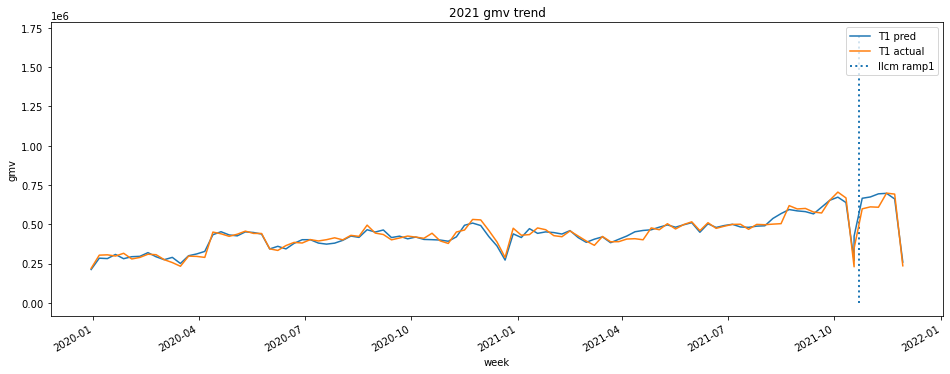

In [58]:
y_actual = data['T1_gmv']
X = data.drop(columns=['period', 'T1_gmv'])

y_pred = clf.predict(X)

y_all = pd.DataFrame(index=y_actual.index, \
                    columns=['T1 pred', 'T1 actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=1700000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv')
plt.title('2021 gmv trend')
plt.legend()

In [63]:
y_all[y_all.index>='2021-10-22'].diff(axis=1).sum()/39

T1 pred         0.00000
T1 actual   -5311.03105
dtype: float64

## CM

In [66]:
pv = ts_T1.groupby(['period', 'week', 'ramp'])['pv_sess'].sum().unstack('ramp').reset_index()
pv.columns = ['period', 'week', 'C1_pv', 'C2_pv', 'T1_pv', 'T2_pv']
pv

cm = ts_T1.groupby(['period', 'week', 'ramp'])['cm'].sum().unstack('ramp').reset_index()
cm.columns = ['period', 'week', 'C1_cm', 'C2_cm', 'T1_cm', 'T2_cm']
data = pv.merge(cm, on=['period', 'week'])

In [67]:
data = data.set_index('week')
data

,period,C1_pv,C2_pv,T1_pv,T2_pv,C1_cm,C2_cm,T1_cm,T2_cm
week,,,,,,,,,
2021-10-18,post,150495.0,127939.0,153072.0,142108.0,19139.306412,21006.487180,15283.972366,18531.830796
2021-10-25,post,339169.0,277103.0,338845.0,337843.0,39666.339002,61973.279538,47658.240812,54071.086954
2021-11-01,post,323386.0,275642.0,310461.0,316920.0,58412.108101,61898.148291,47890.573338,57067.754891
2021-11-08,post,323146.0,309769.0,333597.0,349027.0,36229.966700,46882.879283,26038.919093,-3632.980328
2021-11-15,post,302396.0,270042.0,321643.0,304561.0,46876.969588,47979.714833,43267.161338,47923.188272
...,...,...,...,...,...,...,...,...,...
2021-09-20,pre,352329.0,290274.0,364959.0,317031.0,45721.039290,53289.264678,40198.381454,52092.082377
2021-09-27,pre,345636.0,291106.0,350506.0,326128.0,53392.065750,54178.639634,47498.223861,51352.692885
2021-10-04,pre,384755.0,312074.0,413271.0,353174.0,48196.812326,64320.935960,38220.570606,45649.951693


In [68]:
y_train = data.query('period =="pre"')['T1_cm']
X_train = data.query('period =="pre"').drop(columns=['period', 'T1_cm'])
y_train.shape, X_train.shape

((95,), (95, 7))

In [69]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.7885896178823187

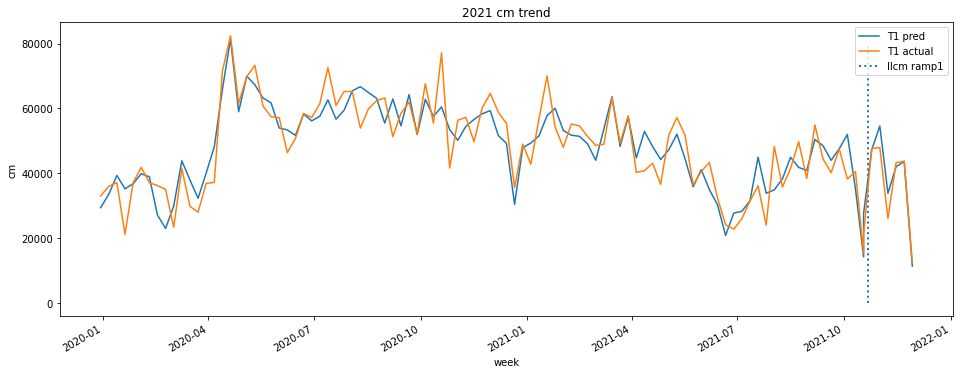

In [72]:
y_actual = data['T1_cm']
X = data.drop(columns=['period', 'T1_cm'])

y_pred = clf.predict(X)

y_all = pd.DataFrame(index=y_actual.index, \
                    columns=['T1 pred', 'T1 actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=80000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

In [73]:
y_all[y_all.index>='2021-10-22'].diff(axis=1).sum()/39

T1 pred        0.000000
T1 actual   -295.367463
dtype: float64

# Bath Vanities

In [88]:
ts_bath = ts.query('l1_category_name=="bath products" and ramp != "T1"') 
ts_bath = ts_bath.assign(bath = np.where(ts_bath['leaf_category_name']=='bathroom vanities and sink consoles', 'vanities', 'other bath'))
ts_bath = ts_bath.assign(period = np.where(ts_bath['dt']<'2021-10-22', 'pre', 'post'))
ts_bath

,dt,wk,ramp,l1_category_name,l2_category_name,leaf_category_name,pv_sess,gmv_w_cancel_est,cm,year,month,week,bath,period
12,2021-10-02,2021W39,T2,bath products,towel bars and hooks,towel bars,1386.0,246.99,35.993922,2021,2021-10-01,2021-09-27,other bath,pre
13,2021-09-04,2021W35,C1,bath products,bathroom fixture parts,toilet handles and levers,176.0,90.99,13.697454,2021,2021-09-01,2021-08-30,other bath,pre
15,2021-08-28,2021W34,T2,bath products,bathroom accessories,soap dishes & holders,76.0,0.00,-2.240000,2021,2021-08-01,2021-08-23,other bath,pre
50,2021-08-22,2021W33,C2,bath products,bathroom accessories,toilet brushes & holders,11.0,0.00,-3.702000,2021,2021-08-01,2021-08-16,other bath,pre
67,2021-09-28,2021W39,C1,bath products,bathroom fixture parts,shower pans and bases,236.0,0.00,-82.808446,2021,2021-09-01,2021-09-27,other bath,pre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547445,2020-11-28,2020W47,C1,bath products,bathroom accessories,bathroom scales,NaN,NaN,NaN,2020,2020-11-01,2020-11-23,other bath,pre
547539,2020-08-20,2020W33,T2,bath products,towels,bathrobes,2.0,NaN,NaN,2020,2020-08-01,2020-08-17,other bath,pre
547541,2021-02-03,2021W5,C2,bath products,bathroom accessories,toilet accessories,NaN,NaN,NaN,2021,2021-02-01,2021-02-01,other bath,pre
547556,2020-05-30,2020W21,T2,bath products,None,bath products,8.0,1499.00,-251.144696,2020,2020-05-01,2020-05-25,other bath,pre


## GMV

In [94]:
['period', 'week'] + [col+'_pv' for col in pv.columns if col not in ['period', 'week']]

['period',
 'week',
 'bathroom accessories_pv',
 'bathroom cabinets_pv',
 'bathroom fixture parts_pv',
 'bathroom fixtures_pv',
 'bathroom shelves_pv',
 'bathroom vanities and sink consoles_pv',
 'medicine cabinets_pv',
 'towel bars and hooks_pv',
 'towels_pv',
 'vanity stools and benches_pv',
 'vanity tops and side splashes_pv']

In [99]:
pv = ts_bath.groupby(['period', 'week', 'l2_category_name'])['pv_sess'].sum().unstack('l2_category_name').reset_index().fillna(0)
# pv.columns = ['period', 'week', 'C1_pv', 'C2_pv', 'T1_pv', 'T2_pv']
pv.columns = ['period', 'week'] + [col+'_pv' for col in pv.columns if col not in ['period', 'week']]

gmv = ts_bath.groupby(['period', 'week', 'l2_category_name'])['gmv_w_cancel_est'].sum().unstack('l2_category_name').reset_index()
gmv.columns = ['period', 'week'] + [col+'_gmv' for col in gmv.columns if col not in ['period', 'week']]

data = pv.merge(gmv, on=['period', 'week'])

In [100]:
data = data.set_index('week')
data

,period,bathroom accessories_pv,bathroom cabinets_pv,bathroom fixture parts_pv,bathroom fixtures_pv,bathroom shelves_pv,bathroom vanities and sink consoles_pv,medicine cabinets_pv,towel bars and hooks_pv,towels_pv,vanity stools and benches_pv,vanity tops and side splashes_pv,bathroom accessories_gmv,bathroom cabinets_gmv,bathroom fixture parts_gmv,bathroom fixtures_gmv,bathroom shelves_gmv,bathroom vanities and sink consoles_gmv,medicine cabinets_gmv,towel bars and hooks_gmv,towels_gmv,vanity stools and benches_gmv,vanity tops and side splashes_gmv
week,,,,,,,,,,,,,,,,,,,,,,,
2021-10-18,post,5864.0,1221.0,19277.0,32935.0,524.0,49759.0,4263.0,5042.0,70.0,499.0,383.0,6287.750000,4369.000000,7757.020000,36796.230000,419.000000,240502.090000,21168.990000,3951.970000,212.000000,238.000000,1878.950000
2021-10-25,post,13226.0,2739.0,37933.0,66676.0,771.0,105831.0,9462.0,9791.0,218.0,1330.0,659.0,15510.000000,5454.990000,41820.030000,104619.220000,712.990000,613755.790000,50938.760000,8882.530000,0.000000,2814.790000,1690.550000
2021-11-01,post,12556.0,2750.0,38608.0,67746.0,831.0,107649.0,9760.0,9921.0,91.0,1229.0,747.0,18966.872000,4387.364690,25671.256663,101180.517386,661.170668,590220.742789,43161.168772,13155.133742,1055.060505,4002.911458,2312.756903
2021-11-08,post,11716.0,2742.0,33921.0,64958.0,744.0,112846.0,10815.0,8762.0,177.0,1089.0,800.0,17904.345532,7469.216839,24513.966728,118450.489235,73.703580,509920.348338,52640.268350,8644.576231,0.000000,1331.451526,1448.348524
2021-11-15,post,10322.0,2613.0,31022.0,61966.0,707.0,97930.0,8337.0,8333.0,462.0,1171.0,666.0,16254.857094,5543.614227,31338.555837,103385.181514,545.499957,515790.164099,34735.298623,9433.866476,446.392063,3695.508803,1154.973839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20,pre,14758.0,2235.0,54061.0,95613.0,1549.0,123540.0,9107.0,13778.0,254.0,1118.0,715.0,16568.560000,6202.080000,22229.710000,114835.850000,733.990000,552382.770000,55180.700000,8299.970000,209.000000,3112.430000,1720.950000
2021-09-27,pre,15305.0,2406.0,49682.0,91471.0,1496.0,129028.0,8885.0,12494.0,252.0,1276.0,662.0,17619.000000,7861.000000,23414.170000,113046.750000,800.000000,600766.260000,55198.900000,14159.010000,260.990000,3592.380000,1371.940000
2021-10-04,pre,14812.0,2808.0,54534.0,89230.0,1404.0,128878.0,9309.0,12796.0,105.0,1380.0,1204.0,20511.190000,4563.990000,20105.470000,122308.800000,461.750000,648365.250000,35245.550000,15359.010000,163.000000,3231.870000,2666.990000


In [101]:
y_train = data.query('period =="pre"')['bathroom vanities and sink consoles_gmv']
X_train = data.query('period =="pre"').drop(columns=['period', 'bathroom vanities and sink consoles_gmv'])
y_train.shape, X_train.shape

((95,), (95, 21))

In [102]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.9102724548050691

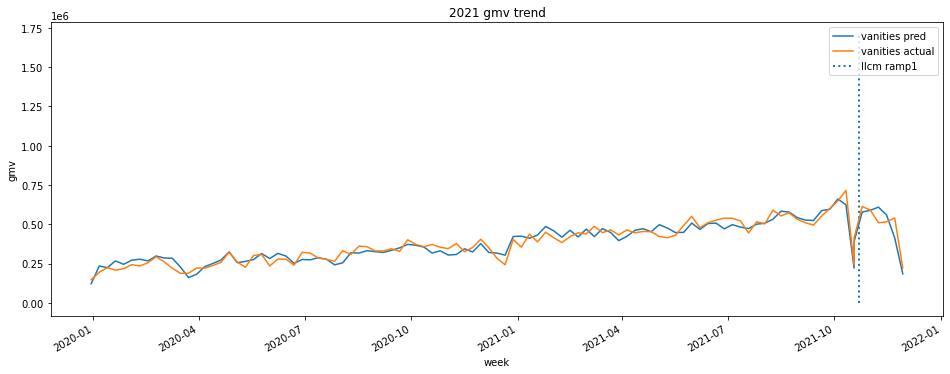

In [104]:
y_actual = data['bathroom vanities and sink consoles_gmv']
X = data.drop(columns=['period', 'bathroom vanities and sink consoles_gmv'])

y_pred = clf.predict(X)

y_all = pd.DataFrame(index=y_actual.index, \
                    columns=['vanities pred', 'vanities actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=1700000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv')
plt.title('2021 gmv trend')
plt.legend()

In [111]:
y_all[y_all.index>='2021-10-22'].diff(axis=1).sum()/39

vanities pred         0.000000
vanities actual    1474.279675
dtype: float64

## CM

In [112]:
pv = ts_bath.groupby(['period', 'week', 'l2_category_name'])['pv_sess'].sum().unstack('l2_category_name').reset_index().fillna(0)
pv.columns = ['period', 'week'] + [col+'_pv' for col in pv.columns if col not in ['period', 'week']]

cm = ts_bath.groupby(['period', 'week', 'l2_category_name'])['cm'].sum().unstack('l2_category_name').reset_index().fillna(0)
cm.columns = ['period', 'week'] + [col+'_cm' for col in cm.columns if col not in ['period', 'week']]

data = pv.merge(cm, on=['period', 'week'])

In [113]:
data = data.set_index('week')
data

,period,bathroom accessories_pv,bathroom cabinets_pv,bathroom fixture parts_pv,bathroom fixtures_pv,bathroom shelves_pv,bathroom vanities and sink consoles_pv,medicine cabinets_pv,towel bars and hooks_pv,towels_pv,vanity stools and benches_pv,vanity tops and side splashes_pv,bathroom accessories_cm,bathroom cabinets_cm,bathroom fixture parts_cm,bathroom fixtures_cm,bathroom shelves_cm,bathroom vanities and sink consoles_cm,medicine cabinets_cm,towel bars and hooks_cm,towels_cm,vanity stools and benches_cm,vanity tops and side splashes_cm
week,,,,,,,,,,,,,,,,,,,,,,,
2021-10-18,post,5864.0,1221.0,19277.0,32935.0,524.0,49759.0,4263.0,5042.0,70.0,499.0,383.0,479.835689,513.968908,-901.585273,899.954148,91.784699,8700.995492,1328.353301,542.463746,40.960597,-41.161757,217.456383
2021-10-25,post,13226.0,2739.0,37933.0,66676.0,771.0,105831.0,9462.0,9791.0,218.0,1330.0,659.0,913.121093,-20.916522,989.106793,6130.339337,128.311483,11120.312613,3543.198096,545.509283,-8.140000,415.172367,82.635621
2021-11-01,post,12556.0,2750.0,38608.0,67746.0,831.0,107649.0,9760.0,9921.0,91.0,1229.0,747.0,2540.753442,-128.545530,-1008.426457,3733.032718,116.151886,25350.471146,4133.321206,1313.405879,104.811685,1080.276091,165.047450
2021-11-08,post,11716.0,2742.0,33921.0,64958.0,744.0,112846.0,10815.0,8762.0,177.0,1089.0,800.0,1909.951222,390.651533,-2808.216476,821.354055,12.198735,7377.276971,4701.388467,454.900424,-8.700000,16.343152,-25.485861
2021-11-15,post,10322.0,2613.0,31022.0,61966.0,707.0,97930.0,8337.0,8333.0,462.0,1171.0,666.0,1581.507313,-64.600416,-741.910295,1675.470679,83.831069,12788.980645,986.954970,891.670166,33.743077,389.717980,-160.043978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20,pre,14758.0,2235.0,54061.0,95613.0,1549.0,123540.0,9107.0,13778.0,254.0,1118.0,715.0,1547.615797,664.364293,-1022.405902,8565.966252,96.085134,19325.551069,1252.896636,391.726700,33.894864,616.286501,130.590179
2021-09-27,pre,15305.0,2406.0,49682.0,91471.0,1496.0,129028.0,8885.0,12494.0,252.0,1276.0,662.0,1746.845458,695.605482,-446.963642,6160.186222,116.592630,23327.287374,5175.324030,2123.145824,49.668109,692.869886,101.335734
2021-10-04,pre,14812.0,2808.0,54534.0,89230.0,1404.0,128878.0,9309.0,12796.0,105.0,1380.0,1204.0,2142.694163,-100.434345,-1016.979344,9646.753925,75.968190,24368.137113,445.533079,1781.055473,20.664738,503.496117,45.664926


In [114]:
y_train = data.query('period =="pre"')['bathroom vanities and sink consoles_cm']
X_train = data.query('period =="pre"').drop(columns=['period', 'bathroom vanities and sink consoles_cm'])
y_train.shape, X_train.shape

((95,), (95, 21))

In [115]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.6313483933085666

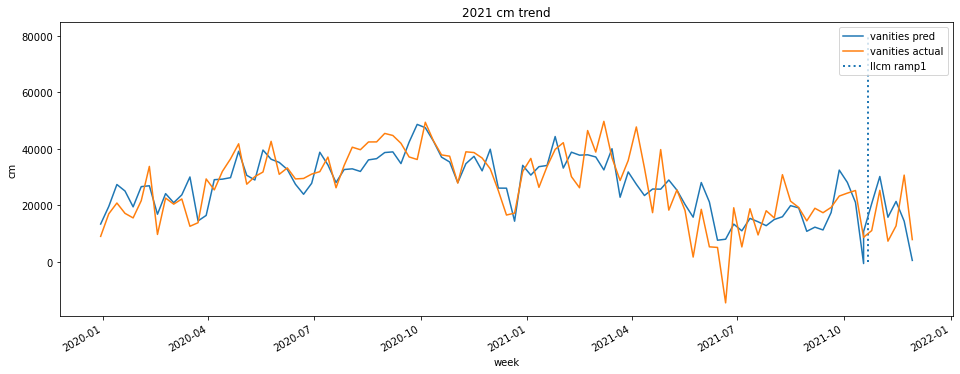

In [116]:
y_actual = data['bathroom vanities and sink consoles_cm']
X = data.drop(columns=['period', 'bathroom vanities and sink consoles_cm'])

y_pred = clf.predict(X)

y_all = pd.DataFrame(index=y_actual.index, \
                    columns=['vanities pred', 'vanities actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=80000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

In [117]:
y_all[y_all.index>='2021-10-22'].diff(axis=1).sum()/39

vanities pred        0.00000
vanities actual   -202.70978
dtype: float64

# Dining tables

In [119]:
# filter for dining products and exclude T1
ts_dining = ts.query('leaf_category_name == "dining tables" or leaf_category_name == "dining chairs"') 
# ts_dining = ts_dining.assign(dining = np.where(ts_dining['leaf_category']=='diningroom vanities and sink consoles', 'vanities', 'other dining'))
ts_dining = ts_dining.assign(period = np.where(ts_dining['dt']<'2021-11-17', 'pre', 'post'))


## GMV

In [120]:
pv = ts_dining.groupby(['period', 'week', 'leaf_category_name'])['pv_sess'].sum().unstack('leaf_category_name').reset_index().fillna(0)
# pv.columns = ['period', 'week', 'C1_pv', 'C2_pv', 'T1_pv', 'T2_pv']
pv.columns = ['period', 'week'] + [col+'_pv' for col in pv.columns if col not in ['period', 'week']]

gmv = ts_dining.groupby(['period', 'week', 'leaf_category_name'])['gmv_w_cancel_est'].sum().unstack('leaf_category_name').reset_index()
gmv.columns = ['period', 'week'] + [col+'_gmv' for col in gmv.columns if col not in ['period', 'week']]

data = pv.merge(gmv, on=['period', 'week'])

In [121]:
data = data.set_index('week')
data

,period,dining chairs_pv,dining tables_pv,dining chairs_gmv,dining tables_gmv
week,,,,,
2021-11-15,post,27712.0,18249.0,118537.838988,76109.039266
2021-11-22,post,39638.0,24181.0,154563.402035,54678.372178
2021-11-29,post,15643.0,9128.0,43287.436065,28638.364496
2019-12-30,pre,19428.0,10322.0,42530.370000,13813.210000
2020-01-06,pre,23462.0,12821.0,34345.300000,11923.860000
...,...,...,...,...,...
2021-10-18,pre,38014.0,25064.0,133226.000000,100646.360000
2021-10-25,pre,45062.0,25379.0,125066.450000,126586.270000
2021-11-01,pre,42947.0,24991.0,169999.127165,109528.264139


In [122]:
y_train = data.query('period =="pre"')['dining tables_gmv']
X_train = data.query('period =="pre"').drop(columns=['period', 'dining tables_gmv'])
y_train.shape, X_train.shape

((99,), (99, 3))

In [123]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.7789708732297846

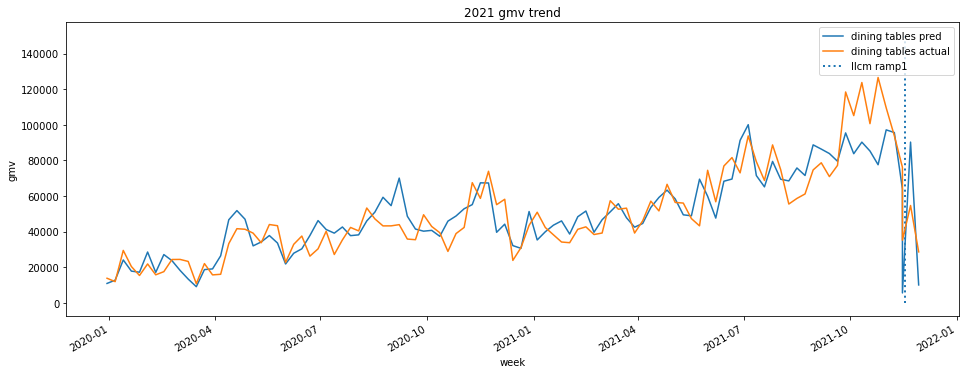

In [126]:
y_actual = data['dining tables_gmv']
X = data.drop(columns=['period', 'dining tables_gmv'])

y_pred = clf.predict(X)

y_all = pd.DataFrame(index=y_actual.index, \
                    columns=['dining tables pred', 'dining tables actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-11-17'), ymin=0, ymax=150000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv')
plt.title('2021 gmv trend')
plt.legend()

In [127]:
y_all[y_all.index>='2021-11-17'].diff(axis=1).sum()/13

dining tables pred         0.000000
dining tables actual   -1309.720476
dtype: float64

## CM

In [128]:
pv = ts_dining.groupby(['period', 'week', 'leaf_category_name'])['pv_sess'].sum().unstack('leaf_category_name').reset_index().fillna(0)
pv.columns = ['period', 'week'] + [col+'_pv' for col in pv.columns if col not in ['period', 'week']]

cm = ts_dining.groupby(['period', 'week', 'leaf_category_name'])['cm'].sum().unstack('leaf_category_name').reset_index().fillna(0)
cm.columns = ['period', 'week'] + [col+'_cm' for col in cm.columns if col not in ['period', 'week']]

data = pv.merge(cm, on=['period', 'week'])

In [129]:
data = data.set_index('week')
data

,period,dining chairs_pv,dining tables_pv,dining chairs_cm,dining tables_cm
week,,,,,
2021-11-15,post,27712.0,18249.0,9850.632279,1664.757732
2021-11-22,post,39638.0,24181.0,14259.395949,-982.511907
2021-11-29,post,15643.0,9128.0,4043.931276,443.238266
2019-12-30,pre,19428.0,10322.0,3207.776387,1825.490137
2020-01-06,pre,23462.0,12821.0,3803.564452,2290.762996
...,...,...,...,...,...
2021-10-18,pre,38014.0,25064.0,11624.942167,-7013.897390
2021-10-25,pre,45062.0,25379.0,10117.056434,-563.528651
2021-11-01,pre,42947.0,24991.0,15838.821885,-180.656236


In [130]:
y_train = data.query('period =="pre"')['dining tables_cm']
X_train = data.query('period =="pre"').drop(columns=['period', 'dining tables_cm'])
y_train.shape, X_train.shape

((99,), (99, 3))

In [131]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.27089384231514146

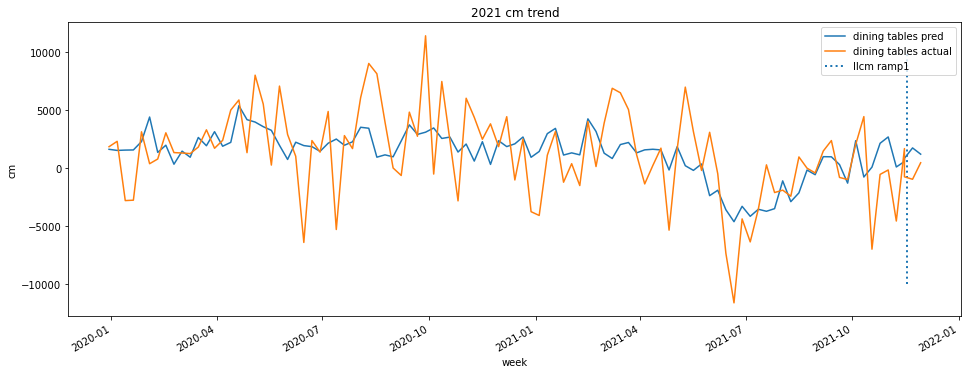

In [135]:
y_actual = data['dining tables_cm']
X = data.drop(columns=['period', 'dining tables_cm'])

y_pred = clf.predict(X)

y_all = pd.DataFrame(index=y_actual.index, \
                    columns=['dining tables pred', 'dining tables actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-11-17'), ymin=-10000, ymax=10000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

In [137]:
y_all[y_all.index>='2021-11-17'].diff(axis=1).sum()/13

dining tables pred        0.000000
dining tables actual   -264.917821
dtype: float64